In [116]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [117]:
df = pd.read_excel('dataset.xlsx')
df.value_counts()

Series([], Name: count, dtype: int64)

In [118]:
missing_rate = df.isna().sum()/df.shape[0]
blood_columns = list(df.columns[(missing_rate<0.9) & (missing_rate>0.88)])
viral_columns = list(df.columns[(missing_rate<0.88) & (missing_rate>0.75)])
viral_columns

['Respiratory Syncytial Virus',
 'Influenza A',
 'Influenza B',
 'Parainfluenza 1',
 'CoronavirusNL63',
 'Rhinovirus/Enterovirus',
 'Coronavirus HKU1',
 'Parainfluenza 3',
 'Chlamydophila pneumoniae',
 'Adenovirus',
 'Parainfluenza 4',
 'Coronavirus229E',
 'CoronavirusOC43',
 'Inf A H1N1 2009',
 'Bordetella pertussis',
 'Metapneumovirus',
 'Parainfluenza 2',
 'Influenza B, rapid test',
 'Influenza A, rapid test']

In [135]:
key_columns = ['Patient age quantile', 'SARS-Cov-2 exam result']
df = df[key_columns+blood_columns+viral_columns]
df.head()


,Patient age quantile,SARS-Cov-2 exam result,Hematocrit,Hemoglobin,Platelets,Mean platelet volume,Red blood Cells,Lymphocytes,Mean corpuscular hemoglobin concentration (MCHC),Leukocytes,...,Adenovirus,Parainfluenza 4,Coronavirus229E,CoronavirusOC43,Inf A H1N1 2009,Bordetella pertussis,Metapneumovirus,Parainfluenza 2,"Influenza B, rapid test","Influenza A, rapid test"
0,13,negative,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,17,negative,0.236515,-0.02234,-0.517413,0.010677,0.102004,0.318366,-0.95079,-0.09461,...,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,negative,negative
2,8,negative,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5,negative,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,15,negative,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,NaN,NaN


**Train test / nettoyage / Encodage**

In [136]:
from sklearn.model_selection import train_test_split

In [137]:
trainset,testset = train_test_split(df,test_size=0.2,random_state=0)
trainset['SARS-Cov-2 exam result'].value_counts()




SARS-Cov-2 exam result
negative    4068
positive     447
Name: count, dtype: int64

In [138]:
def encodage(df):
    code = {
        'positive':1,
        'negative':0,
        'detected':1,
        'not_detected':0
    }
    for col in df.select_dtypes('object').columns:
        df.loc[:,col] = df[col].map(code)

    return df


In [139]:
def feature_engineering(df):
    df['est malade'] = df[viral_columns].sum(axis=1) >=1
    df = df.drop(viral_columns,axis=1)
    return df

In [140]:
def imputation(df):
    return df.dropna(axis=0)


In [141]:
def preprocessing(df):
    df = encodage(df)
    df = feature_engineering(df)
    df = imputation(df)

    X = df.drop('SARS-Cov-2 exam result',axis=1)
    y = df['SARS-Cov-2 exam result'].astype(int)

    print(y.value_counts())

    return X,y


In [142]:
X_train , y_train = preprocessing(trainset)


SARS-Cov-2 exam result
0    422
1     65
Name: count, dtype: int64


In [143]:
y_train.head()

543     0
203     0
1624    1
500     0
34      0
Name: SARS-Cov-2 exam result, dtype: int64

In [144]:
X_test , y_test = preprocessing(testset)


SARS-Cov-2 exam result
0    95
1    16
Name: count, dtype: int64


**Modelisation**


In [161]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import f1_score,confusion_matrix,classification_report
from sklearn.model_selection import learning_curve

preprocessor = make_pipeline(PolynomialFeatures(2,include_bias=False),(SelectKBest(f_classif,k=10)))
RandomForest = make_pipeline(preprocessor,
                      RandomForestClassifier(random_state=0))
AdaBoost = make_pipeline(preprocessor,
                      AdaBoostClassifier(random_state=0))
SVM = make_pipeline(preprocessor,StandardScaler(),
                      SVC(random_state=0))
KNN = make_pipeline(preprocessor,StandardScaler(),
                      KNeighborsClassifier())


In [158]:
def evaluation(model):
    model.fit(X_train,y_train)
    y_pred=model.predict(X_test)

    print(confusion_matrix(y_test,y_pred))
    print(classification_report(y_test,y_pred))

    N,train_score,val_score = learning_curve(model,X_train,y_train,cv=4,scoring='f1',train_sizes=np.linspace(0.1,1,10))

    plt.figure(figsize=(12,8))
    plt.plot(N,train_score.mean(axis=1),label='train score')
    plt.plot(N,val_score.mean(axis=1),label='validation score')
    plt.legend()
                                             


**Model Selection**


RandomForest
[[91  4]
 [10  6]]
              precision    recall  f1-score   support

           0       0.90      0.96      0.93        95
           1       0.60      0.38      0.46        16

    accuracy                           0.87       111
   macro avg       0.75      0.67      0.70       111
weighted avg       0.86      0.87      0.86       111

AdaBoost
[[90  5]
 [11  5]]
              precision    recall  f1-score   support

           0       0.89      0.95      0.92        95
           1       0.50      0.31      0.38        16

    accuracy                           0.86       111
   macro avg       0.70      0.63      0.65       111
weighted avg       0.83      0.86      0.84       111

SVM
[[91  4]
 [ 9  7]]
              precision    recall  f1-score   support

           0       0.91      0.96      0.93        95
           1       0.64      0.44      0.52        16

    accuracy                           0.88       111
   macro avg       0.77      0.70      0.73  

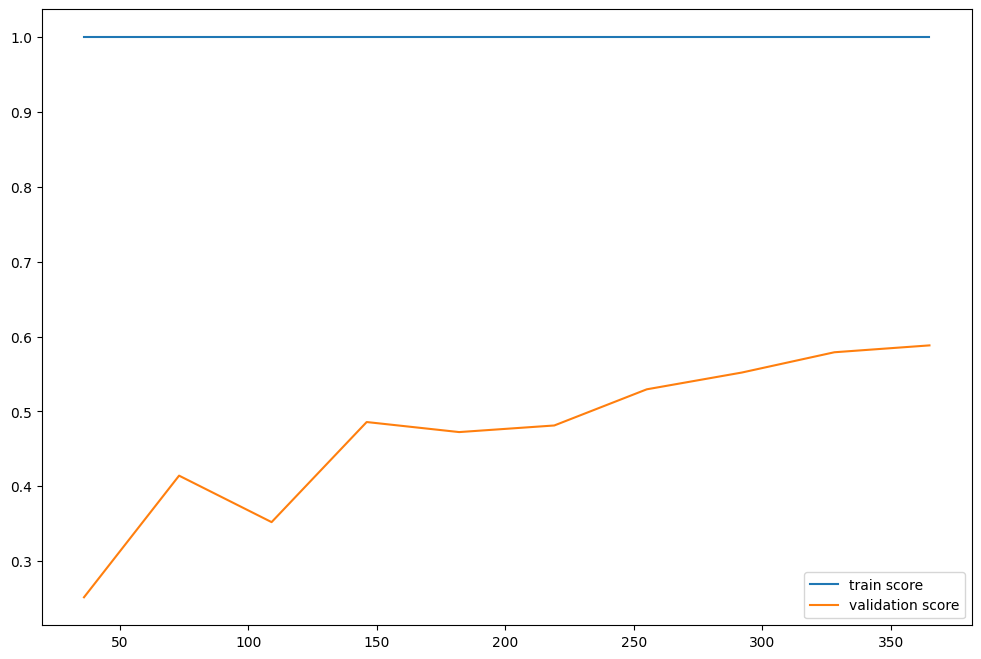

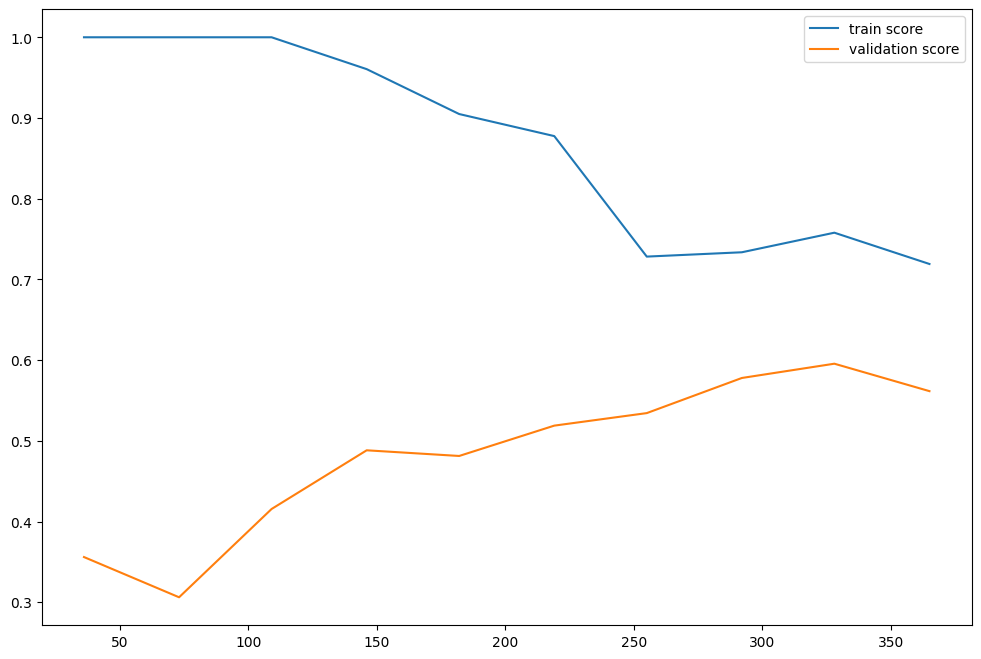

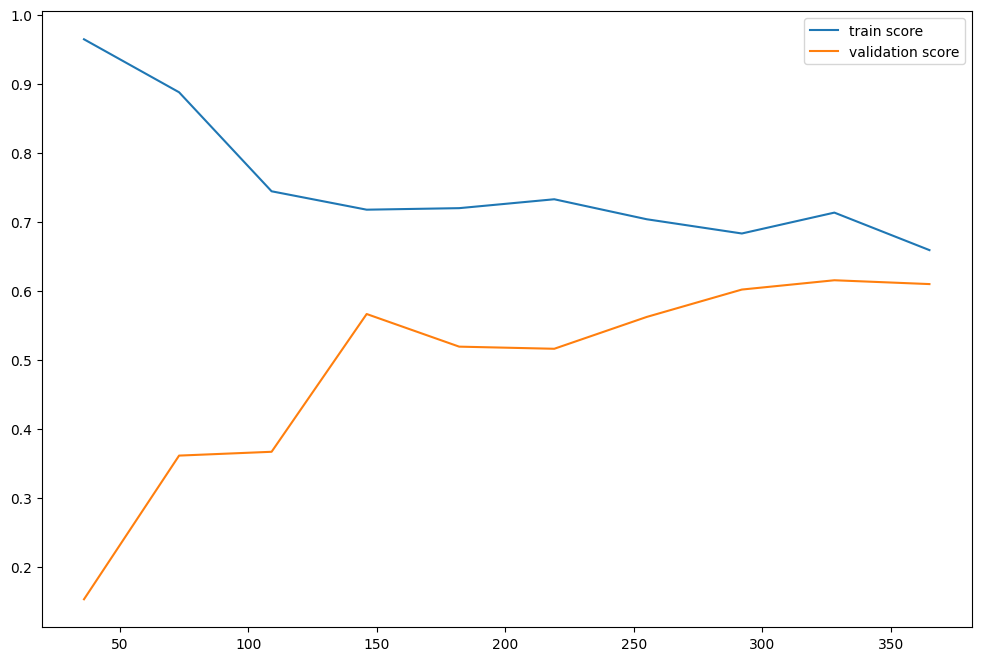

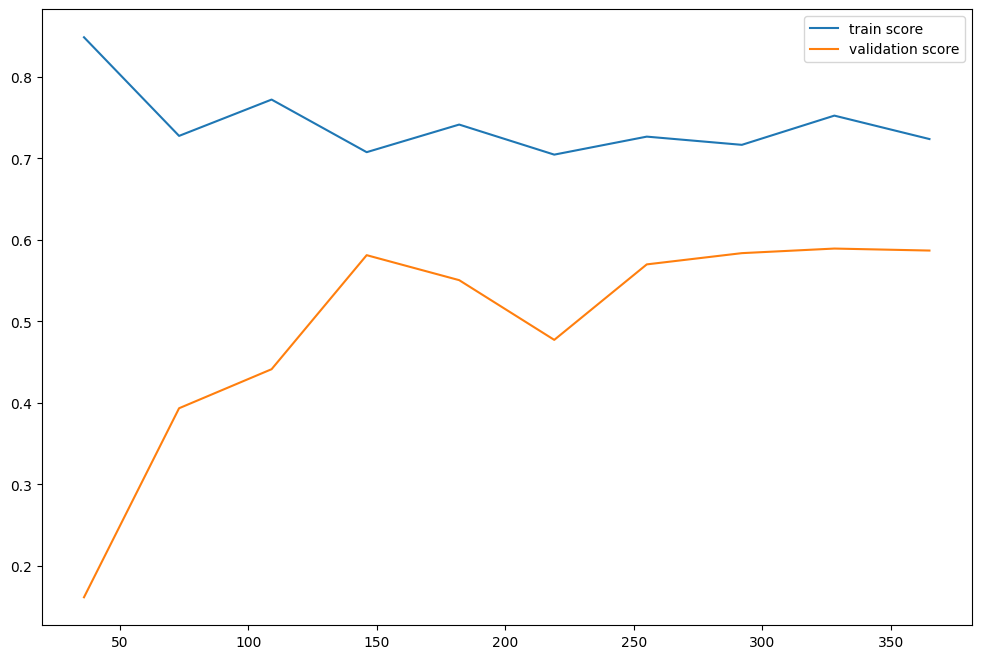

In [162]:
list_of_models = {'RandomForest':RandomForest,
                  'AdaBoost':AdaBoost,
                  'SVM':SVM,
                  'KNN':KNN
                  }
for name,model in list_of_models.items():
    print(name)
    evaluation(model)

<Axes: >

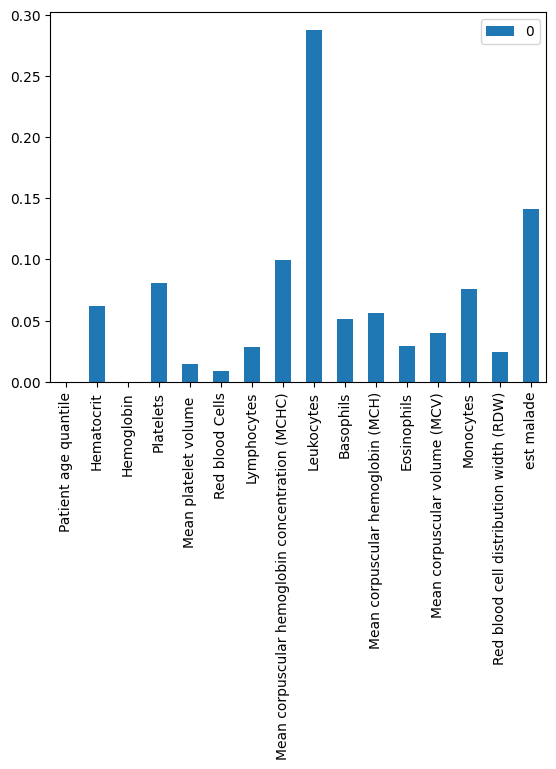

In [149]:
pd.DataFrame(model.feature_importances_,index=X_train.columns,).plot.bar()

**Optimisation Adaboost**

In [186]:
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV

AdaBoost

hyper_params= {
    'adaboostclassifier__n_estimators' : [100,150,200],
    'adaboostclassifier__learning_rate' : [1,1.5,2,2.5],
    'pipeline__polynomialfeatures__degree':[2,3,4],
    'pipeline__selectkbest__k':range(40,60)
}



In [189]:
grid = RandomizedSearchCV(AdaBoost,hyper_params,scoring='recall',cv=4,n_iter=40)
grid.fit(X_train,y_train)
print(grid.best_params_)
y_pred = grid.predict(X_test)
print(classification_report(y_test,y_pred))

{'pipeline__selectkbest__k': 56, 'pipeline__polynomialfeatures__degree': 2, 'adaboostclassifier__n_estimators': 150, 'adaboostclassifier__learning_rate': 2}
              precision    recall  f1-score   support

           0       0.96      0.58      0.72        95
           1       0.26      0.88      0.40        16

    accuracy                           0.62       111
   macro avg       0.61      0.73      0.56       111
weighted avg       0.86      0.62      0.68       111



**Optimisation SVM**

In [185]:
from sklearn.model_selection import RandomizedSearchCV
hyper_params1 = {
    'svc__C':[1,100,1000],
    'svc__gamma':[1e-3,1e-4],
    'pipeline__polynomialfeatures__degree':[2,3,4],
    'pipeline__selectkbest__k':range(40,60)
}

grid1 = RandomizedSearchCV(SVM,hyper_params1,scoring='recall',cv=4,n_iter=40)
grid1.fit(X_train,y_train)
print(grid1.best_params_)
y_pred1 = grid1.predict(X_test)
print(classification_report(y_test,y_pred1))

{'svc__gamma': 0.001, 'svc__C': 1000, 'pipeline__selectkbest__k': 53, 'pipeline__polynomialfeatures__degree': 3}
              precision    recall  f1-score   support

           0       0.95      0.92      0.93        95
           1       0.58      0.69      0.63        16

    accuracy                           0.88       111
   macro avg       0.76      0.80      0.78       111
weighted avg       0.89      0.88      0.89       111



[[87  8]
 [ 5 11]]
              precision    recall  f1-score   support

           0       0.95      0.92      0.93        95
           1       0.58      0.69      0.63        16

    accuracy                           0.88       111
   macro avg       0.76      0.80      0.78       111
weighted avg       0.89      0.88      0.89       111



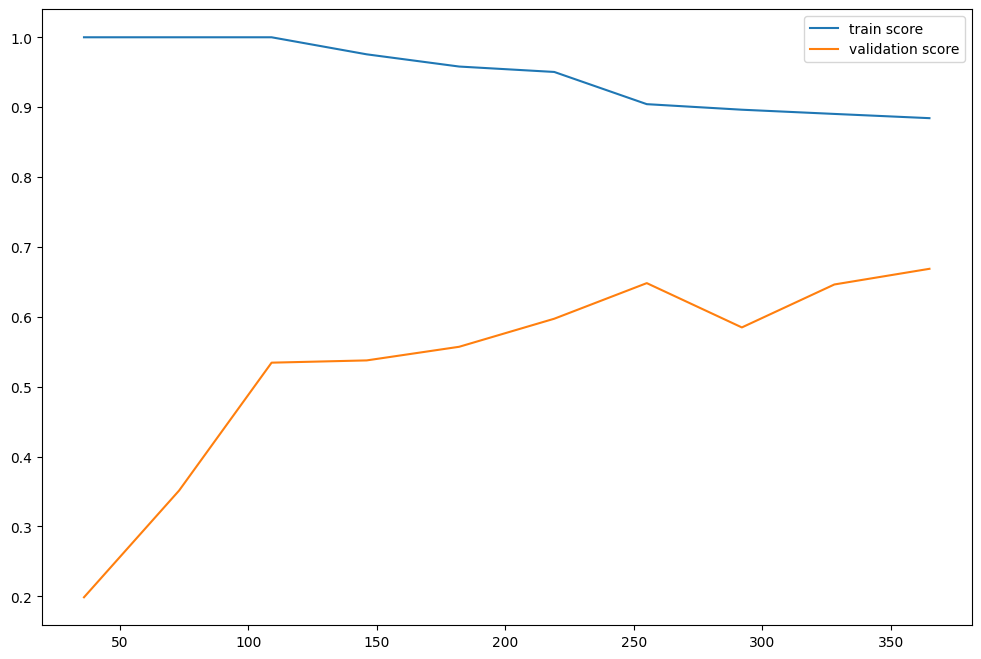

In [190]:
evaluation(grid1.best_estimator_)

**Precision Recall Curve**

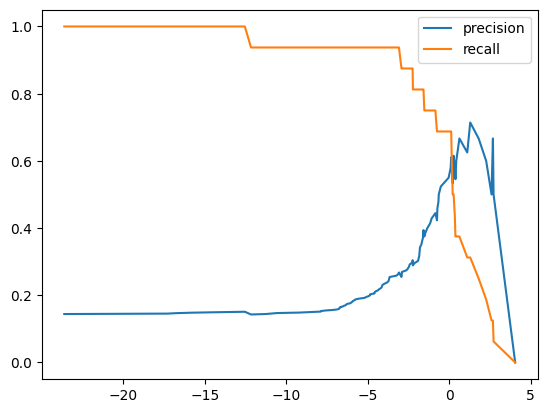

In [191]:
from sklearn.metrics import precision_recall_curve
precision,recall,threshold = precision_recall_curve(y_test,grid1.best_estimator_.decision_function(X_test))

plt.plot(threshold,precision[:-1],label='precision')
plt.plot(threshold,recall[:-1],label='recall')
plt.legend()

In [192]:
def model_final(model,X,threshold=0):
    return model.decision_function(X) > threshold


In [194]:
y_pred = model_final(grid1.best_estimator_,X_test,threshold=-1)


In [196]:
f1_score(y_test,y_pred)

0.5581395348837209

In [197]:
from sklearn.metrics import recall_score

recall_score(y_test,y_pred)

0.75